# Task1 赛题理解

项目名称：零基础入门CV之街道字符识别

训练集数据包括3W张照片，验证集数据包括1W张照片，每张照片包括颜色图像和对应的编码类别和具体位置(top, height, left,width,label)；
所有的数据（训练集、验证集和测试集）的标注使用JSON格式，并使用文件名进行索引。如果一个文件中包括多个字符，则使用列表将字段进行组合。
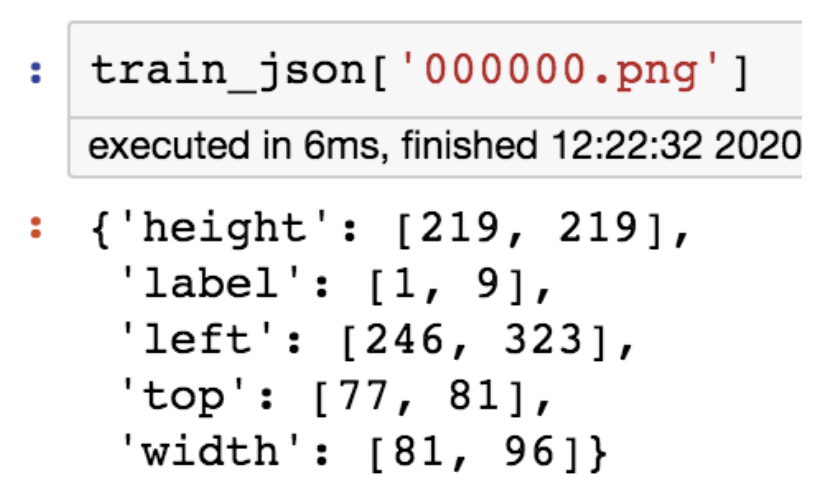

### 1.1读取数据

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

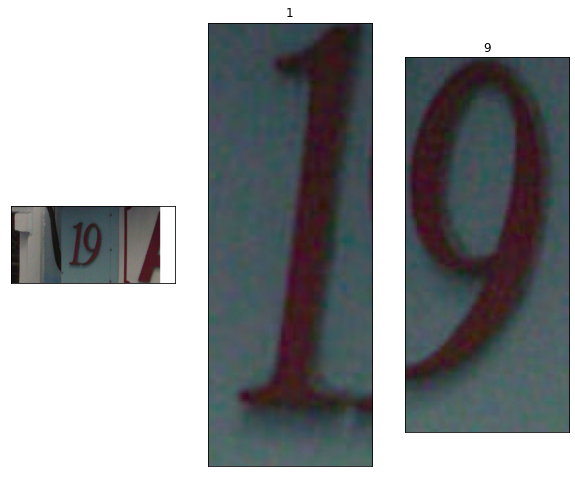

In [26]:
import json
train_json = json.load(open('./train.json'))

#数据标注处理
def parse_json(d):
    arr = np.array([
        d['top'], d['height'], d['left'], d['width'], d['label']
    ])
    arr = arr.astype(int)
    return arr

img = cv2.imread('./train/000000.png')
arr = parse_json(train_json['000000.png'])

plt.figure(figsize=(10,10))
plt.subplot(1,arr.shape[1]+1, 1)
plt.imshow(img)
plt.xticks([])
plt.yticks([])

for idx in range(arr.shape[1]):
    plt.subplot(1, arr.shape[1]+1, idx+2)
    plt.imshow(img[arr[0, idx]:arr[0, idx]+arr[1, idx],arr[2, idx]:arr[2, idx]+arr[3, idx]])
    plt.title(arr[4, idx])
    plt.xticks([]); plt.yticks([])

### 1.2 解题思路
定长字符识别：赛题数据集中大部分图像中字符个数为2-4个，最多的字符 个数为6个。
因此可以对于所有的图像都抽象为6个字符的识别问题，字符23填充为23XXXX
检测再识别：数据中已经给出了训练集、验证集中所有图片中字符的位置，因此可以首先将字符的位置进行识别，利用物体检测的思路完成参考物体检测模型SSD或者YOLO来完成。





# Task2 数据读取与数据扩增

### 2.1 数据读取

#### 2.1.1 Pillow

In [ ]:
from PIL import Image, ImageDraw, ImageFont, ImageFilter
import random

# 打开一个jpg图像文件，注意是当前路径:
im = Image.open('./train/000000.png')

# 获得图像尺寸:
w, h = im.size

# 缩放到50%:
im.thumbnail((w//2, h//2))
print('Resize image to: %sx%s' % (w//2, h//2))


# 随机字母:
def rndChar():
    return chr(random.randint(65, 90))

# 随机颜色1:
def rndColor():
    return (random.randint(64, 255), random.randint(64, 255), random.randint(64, 255))

# 随机颜色2:
def rndColor2():
    return (random.randint(32, 127), random.randint(32, 127), random.randint(32, 127))

# 240 x 60:
width = 60 * 4
height = 60
image = Image.new('RGB', (width, height), (255, 255, 255))
# 创建Font对象:
font = ImageFont.truetype('Arial.ttf', 36)
# 创建Draw对象:
draw = ImageDraw.Draw(image)
# 填充每个像素:
for x in range(width):
    for y in range(height):
        draw.point((x, y), fill=rndColor())
# 输出文字:
for t in range(4):
    draw.text((60 * t + 10, 10), rndChar(), font=font, fill=rndColor2())
# # 应用模糊滤镜:
image = image.filter(ImageFilter.BLUR)
image.save('code.jpg', 'jpeg')
#by liaoxuefeng

#### 2.1.1 Opencv

In [ ]:
    #一个人脸检测的例子fromjiqizhixin
    import cv2  
    
    # Create a CascadeClassifier Object  
    face_cascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")  

    # Reading the image as it is  
    img = cv2.imread("./face.png") 
    # Reading the image as gray scale image  
    gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)  
    # Search the co-ordintes of the image  
    faces = face_cascade.detectMultiScale(gray_img, scaleFactor = 1.05,  minNeighbors=5)  

    for x,y,w,h in faces:  
        img = cv2.rectangle(img, (x,y), (x+w,y+h),(0,255,0),3)  
    
    resized = cv2.resize(img, (int(img.shape[1]/7),int(img.shape[0]/7)))   

    cv2.imshow("Gray", resized)  
    cv2.waitKey(0)  
    cv2.destroyAllWindows()  

### 2.2 数据扩增
数据扩增可以增加训练集的样本，同时也可以有效缓解模型过拟合的情况，也可以给模型带来的更强的泛化能力

在常见的数据扩增方法中，一般会从图像颜色、尺寸、形态、空间和像素等角度进行变换。当然不同的数据扩增方法可以自由进行组合，得到更加丰富的数据扩增方法。

以torchvision为例，常见的数据扩增方法包括：

    transforms.CenterCrop 对图片中心进行裁剪
    transforms.ColorJitter 对图像颜色的对比度、饱和度和零度进行变换
    transforms.FiveCrop 对图像四个角和中心进行裁剪得到五分图像
    transforms.Grayscale 对图像进行灰度变换
    transforms.Pad 使用固定值进行像素填充
    transforms.RandomAffine 随机仿射变换
    transforms.RandomCrop 随机区域裁剪
    transforms.RandomHorizontalFlip 随机水平翻转
    transforms.RandomRotation 随机旋转
    transforms.RandomVerticalFlip 随机垂直翻转


### 2.3 Pytorch读取数据

Dataset：对数据集的封装，提供索引方式的对数据样本进行读取

DataLoder：对Dataset进行封装，提供批量读取的迭代读取

In [ ]:
import os, sys, glob, shutil, json
import cv2

from PIL import Image
import numpy as np

import torch
from torch.utils.data.dataset import Dataset
import torchvision.transforms as transforms

class SVHNDataset(Dataset):
    def __init__(self, img_path, img_label, transform=None):
        self.img_path = img_path
        self.img_label = img_label 
        if transform is not None:
            self.transform = transform
        else:
            self.transform = None

    def __getitem__(self, index):
        img = Image.open(self.img_path[index]).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)
        
        # 原始SVHN中类别10为数字0
        lbl = np.array(self.img_label[index], dtype=np.int)
        lbl = list(lbl)  + (5 - len(lbl)) * [10]
        
        return img, torch.from_numpy(np.array(lbl[:5]))

    def __len__(self):
        return len(self.img_path)

train_path = glob.glob('../input/train/*.png')
train_path.sort()
train_json = json.load(open('../input/train.json'))
train_label = [train_json[x]['label'] for x in train_json]

train_loader = torch.utils.data.DataLoader(
        SVHNDataset(train_path, train_label,
                   transforms.Compose([
                       transforms.Resize((64, 128)),
                       transforms.ColorJitter(0.3, 0.3, 0.2),
                       transforms.RandomRotation(5),
                       transforms.ToTensor(),
                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])), 
    batch_size=10, # 每批样本个数
    shuffle=False, # 是否打乱顺序
    num_workers=10, # 读取的线程个数
)

for data in train_loader:
    break